## 1. Recap: the problem of introducing a state


Our goal is to explanation the perservation effect in the probability tracking task. 

In [2]:
import numpy as np 
import pandas as pd 
from scipy.special import softmax

# visualizatioion pkg 
import seaborn as sns 
import matplotlib.pyplot as plt 
%matplotlib inline
%config InlineBackend.figure_format='retina'

import sys 
sys.path.append("..") 
from utils.viz import viz 
viz.get_style()

### 1.1 the state design

![Image](https://pic4.zhimg.com/80/v2-172f1186b541ecf10471f0d503228fd5.png)

### 1.2 the reviewers' comments

> 
> In particular, the following shortcomings were mentioned:
> 1. The current model performs worse than Gagne et al.'s original model and the explanation that this is not that important seems not too convincing. In general, having previously also read the Gagne paper, the model comparison here is done on a small subset of people and using much more basic tools (BIC vs. Bayesian model comparison in the original).
> 2. When running the model forward, it does not perform as people do, so clearly, something substantial here is missing.
> 3. Currently, as pointed out by reviewer 2, the rewards available in the current trial are not part of the state of the model. It remains, therefore, unclear if this model could ever be a rational model for the task.
> 

In summary, the effect is not **unconvincing** and **trival**. 

### 1.3 the problem of introducing the concept "state"

Not deterministic enough! 

In [8]:
def policyWithState(m, p, q, beta=2):
    m_sa = np.eye(len(m))*m
    p = p.reshape([-1, 1])
    q = q.reshape([1, -1])
    return (p.T@softmax(beta*m_sa + np.log(q), axis=1)).reshape([-1])

def improved(m, p, q, beta=2, beta2=7):
    return softmax(beta2*policyWithState(m, p, q, beta))


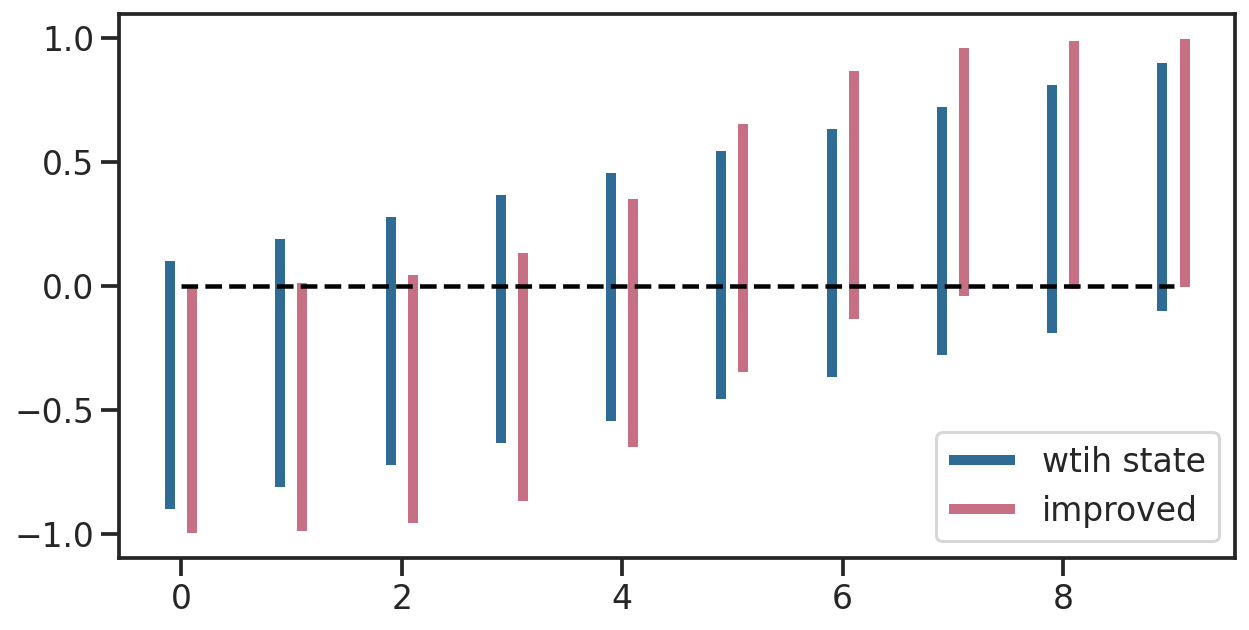

In [39]:
m  = np.array([29, 78])
pS = np.linspace(.1, .9, 10)
q  = np.array([.6, .4])

probs = np.zeros([2, 10]) + np.nan 
for i, ps in enumerate(pS):
    p = np.array([ps, 1-ps])
    probs[0, i] = policyWithState(m, p, q)[0]
    probs[1, i] = improved(m, p, q)[0]

plt.figure(figsize=(10, 5))
x = np.arange(10)
for i in range(10):
    plt.vlines(x=x[i]-.1, ymax=probs[0, i], ymin=probs[0, i]-1, color=viz.Blue, lw=5)
    plt.vlines(x=x[i]+.1, ymax=probs[1, i], ymin=probs[1, i]-1, color=viz.Red, lw=5)
    if i == 0: plt.legend(['wtih state', 'improved'], loc='lower right')
plt.plot(x, 10*[0], color='k', ls='--')
plt.show()

## 2 A new formulation

### 2.1 Background

The probability tracking task can be framed as a simple multi-task problem, where each trial is a task. As a result of compression, an agent will use similar policies in all trials in a multi-task problem, which is formalized as minimizing the KL divergence between policies $\pi(a;m_1,m_2)$ and a default one $\pi_0(a)$. (Tirumala et al, 2020)[https://arxiv.org/pdf/1903.07438.pdf]. The default policy can be understood as a prior of all policy, and this phenomenon can be understood as perseveration.

### 2.2 The decision rule

Follow this idea, we can construct the decision rule as, 

$$\max_{\pi} \mathbb{E}[U(a)] - \lambda\mathbb{E}[\log\frac{\pi(a)}{\pi_0(a)}]$$

where the $U(a) = \langle \left[\begin{matrix}p(a_1)\\p(a_2)\end{matrix}\right],  \left[\begin{matrix}m_1\\m2\end{matrix}\right]\rangle$

The analytical solution is,

$$\pi(a) \propto \exp\left(\frac{U(a)}{\lambda} + \log \pi_0(a)\right)$$


### 2.3 The model

The agent should maintain the following constructs, the rewarding probability $p(a)$, the default policy $\pi_0(a)$. Each trial, the agent is given feedback $o$ the outcome. 

The update rule follow,

$$p(a) =  \alpha[o(a) - p(a)]$$

$$\pi_0(a) =  \alpha[\mathbb{I}(a) - \pi_0(a)]$$

And the decision rule is, 

$$\pi(a) \propto \exp\left(\frac{U(a)}{\lambda} + \log \pi_0(a)\right)$$

Parameters:

$$\alpha_{\text{sta}}, \alpha_{\text{vol}}, \lambda_{\text{sta}}, \lambda_{\text{vol}}, \alpha_{\pi}$$ 

### 2.4 The performance

Gagne's best model

    * Nll:  68.02
    * Aic:  151.95

New model

    * Nll:  74.01
    * Aic:  160.18

### 2.5 The secret behind the success of Gagne's best model

#### Claim: 

The gagne's model is more magnitude sensitive.

#### Evidence: 

We can rearrange the decision rule into the following addictive formula, 

$$U(a) = w_1p(a) + w_2p(a)m(a) + w_3m(a) + (1-w_1 -w_2-w_3)\pi_0(a)$$

$$\pi(a)\propto \exp(\beta U(a))$$

We exclude the power law on the magnitude for simplicity.

The gagne's best model (with power law on magnitude)

    * Nll:  68.02
    * Aic:  151.95

The rearrange model (without power law)

    * Nll: 69.06
    * Aic: 152.13

This result suggest that our rearranged model replicates the original gagne model.



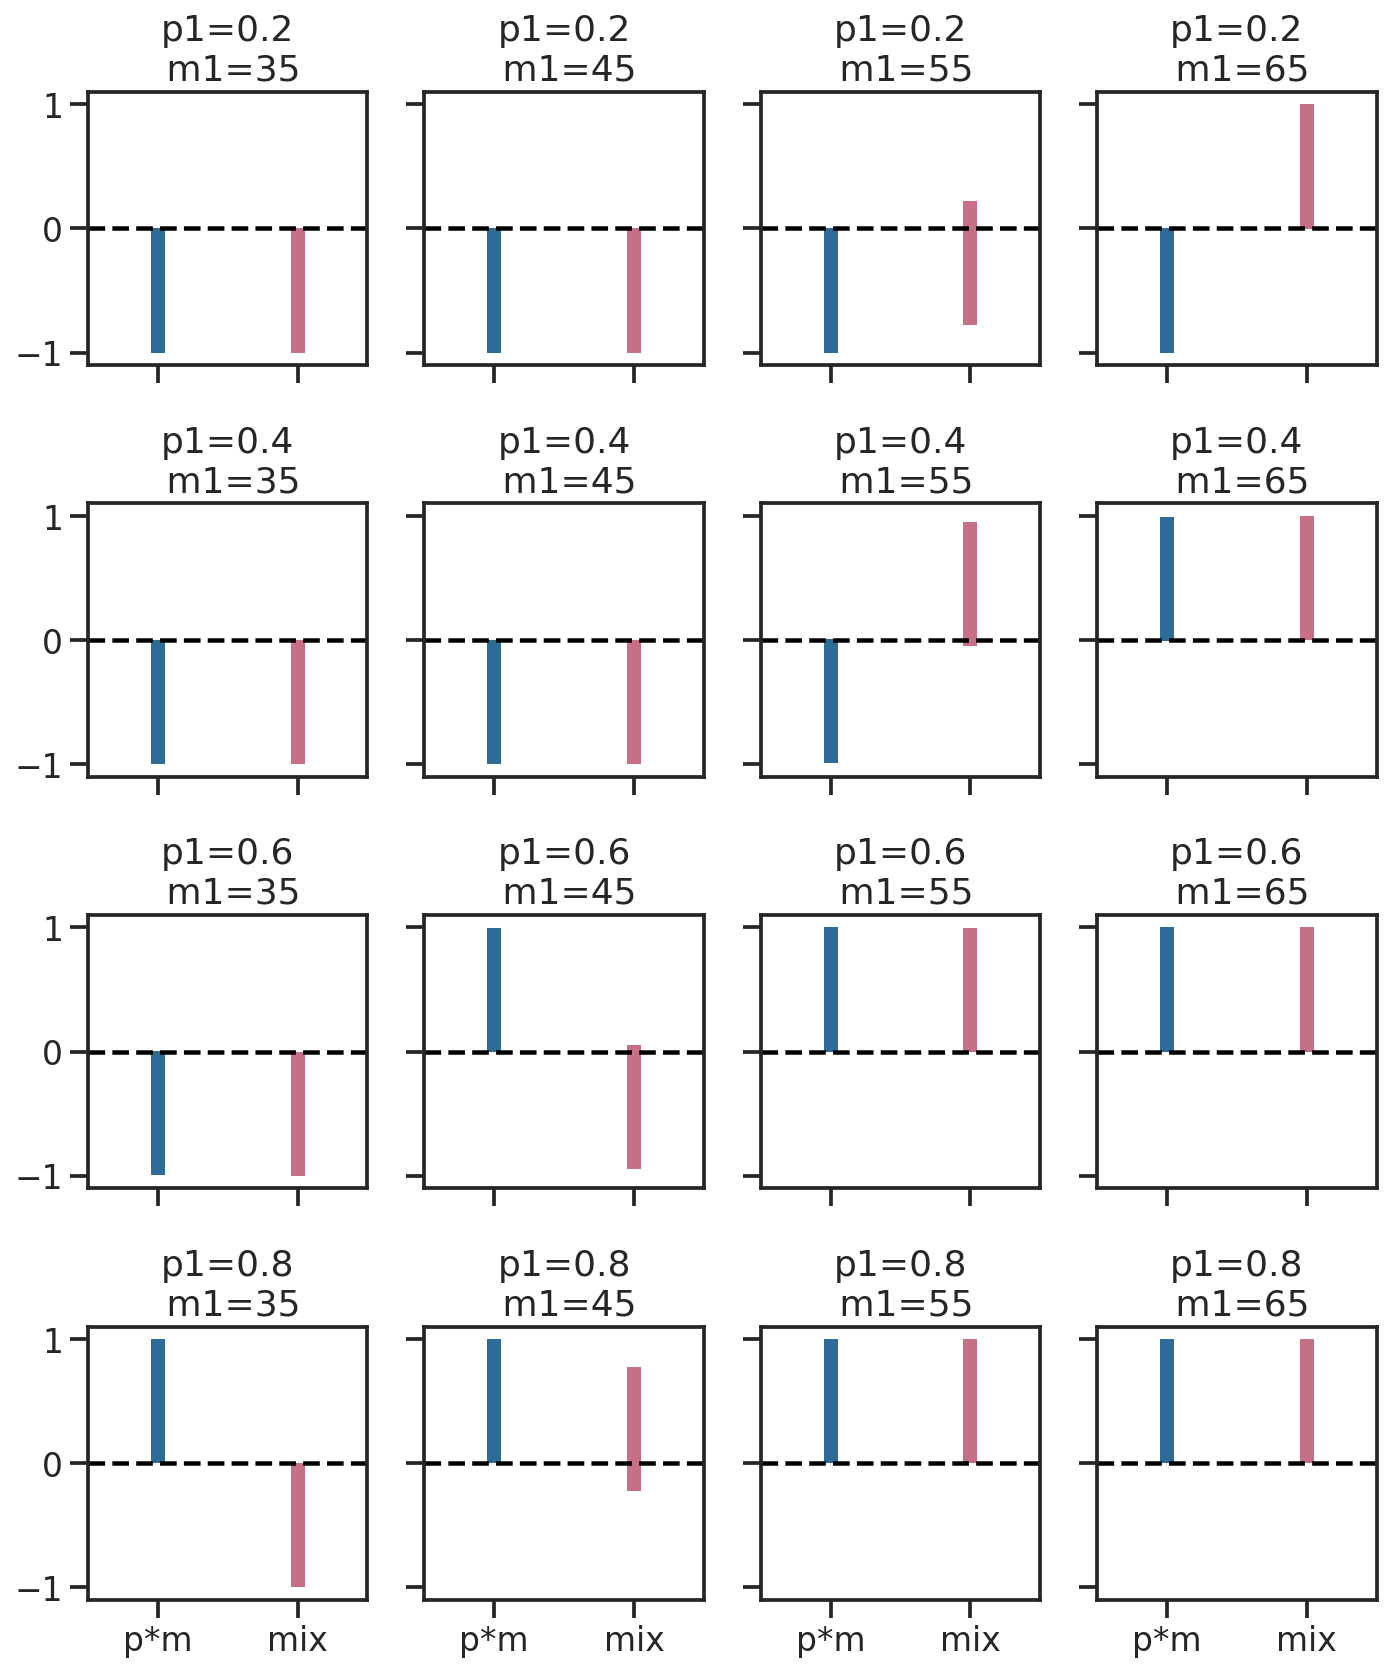

In [46]:
pS = [.2, .4, .6, .8]
mS = [35, 45, 55, 65]

eU  = lambda p, u: softmax(p*u)[0]
mix = lambda p, u: softmax(.2*p*u + .4*p + .4*u)[0]

probs = np.zeros([2, 4, 4]) + np.nan 
for i in range(4):
    for j in range(4):
        p, m = pS[i], mS[j]
        probs[0, i, j] = eU(np.array([p, 1-p]), np.array([m, 100-m]))
        probs[1, i, j] = mix(np.array([p, 1-p]), np.array([m, 100-m]))

fig, axs = plt.subplots(4, 4, figsize=(10, 12), sharex=True, sharey=True)
for i in range(4):
    for j in range(4):
        ax = axs[i, j]
        ax.vlines(x=-.2, ymax=probs[0, i, j], ymin=probs[0, i, j]-1, color=viz.Blue, lw=7)
        ax.vlines(x=.2,  ymax=probs[1, i, j], ymin=probs[1, i, j]-1, color=viz.Red, lw=7)
        ax.plot(np.linspace(-.4, .4, 10), [0]*10, ls='--', color='k')
        ax.set_xlim([-.4, .4])
        ax.set_title(f'p1={pS[i]}\n m1={mS[j]}')
        if i == 3: 
            ax.set_xticks([-.2, .2])
            ax.set_xticklabels(['p*m', 'mix'])
plt.tight_layout()
plt.show()

## 3. What's next 

### 3.1 Three reasons to publish a model

From strong to weak: 

1. The model captures an unseen effect (which can be exposed by pure data aggregation without a model) that the current model do not. 
2. The model has a better quantitative fit.
3. The model is simpler and more theoretically soundly than the current model that captures the same qualitative effect; slightly lower performance on the quantitative criteria is acceptable. 

The third reason makes sense only because of one common sense---all experimental data is noisy. 

## Possible directions

1. The perseveration effect

    * Pros: 
        1. Have theoretic support
        2. Minimal works
    * Cons:
        1. Worse fit. 
        2. Fitting seperate parameters does not lead to significantly better fit.
        3. The effect is not easily recognizable. It is twisted with the probabilistic tracking effect for both behavioral and neuroscience data. 

2. The epistemic uncertainty

    Challenge the HGF, maybe there is no volatility level. Does HGF really fit the human behavior? 

    This method is rarely used in the modern RL algorithm because it is not generalizable. 

    ![Image](https://pic4.zhimg.com/80/v2-0ed03e8db20317335772b461f33b7f66.png)